## Cab-Driver Agent

### Problem Statement

The goal of the project is to build an RL-based algorithm which can help cab drivers maximise their profits by improving their decision-making process on the field.

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
# Checking max, min, mean values in the matrix
print(Time_matrix.max())
print(Time_matrix.min())
print(Time_matrix.mean())

11.0
0.0
3.0542857142857143


### Architecture 1 

The input to the NN is both state and action. For choosing the maxaQ(s′,a), for a particular state, we have to input every possible action, calculate its Q-value and choose the action for which Q-value is maximum.

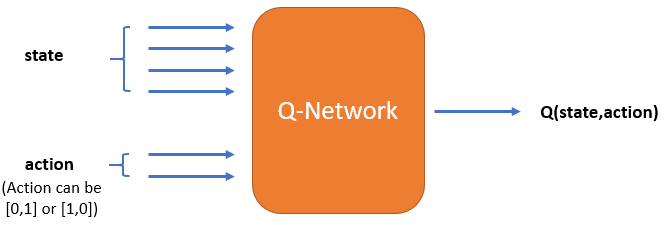

### Architecture 2

The input to the NN is only the state and its output is the Q-value of every possible action. Here, the size. 

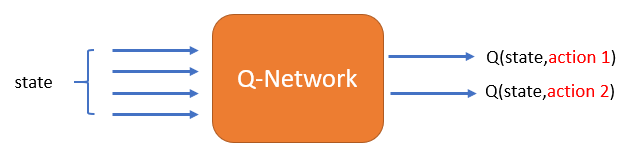

### Agent Class

We are using acrhitecture 1 to solve this problem. The major steps are as follows:

1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

#### Defining class DQNAgent

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.01  
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005
        self.epsilon_min = 0.00001
        
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        input_shape = self.state_size
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
         # the output layer is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model


    def get_action(self, state, possible_actions_index, actions):
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from the ride requests
            return random.choice(possible_actions_index)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Use the model to predict the Q_values.
            q_value = self.model.predict(state)

            # Lets keep only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]                            


    def append_sample(self, state, action_index, reward, next_state, done):
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action_index, reward, next_state, done))    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialize update_input and update_output
            update_output = np.zeros((self.batch_size, self.state_size))
            update_input = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]              
                # update 'update_output' and 'update_input' batch
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)
                
            # Predict the target from earlier model
            target = self.model.predict(update_input)
                                
            # Get the target for the Q-network
            target_qval = self.model.predict(update_output)               

            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)


    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        with open(name + '.pkl', 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)
            

### DQN block

for episode in range(Episodes):

    
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent
    
    
    while !terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        

In [5]:
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = 4500 
m = 5
t = 24
d = 7

# Invoking Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Setting up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoking agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# Storing rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

## Train the Model

The moment total episode time exceeds 720 (30 days), we ignore the most recent ride and do NOT save that experience in the replay memory

The init state is randomly picked from the state space for each episode

In [6]:
#Run the episodes, build up replay buffer and train the model.

start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    while not done:
        # 1. Get a list of the ride requests driver got.
        possible_actions_indices, actions = env.requests(state)
        # 2. Pick epsilon-greedy action from possible actions for the current state.
        action = agent.get_action(state, possible_actions_indices, actions)

        # 3. Evaluate your reward and next state
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        # 4. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # if ride does not complete in stipu;ated time skip
            # it and move to next episode.
            done = True
        else:
            # 5. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)
            # 6. Train the model by calling function agent.train_model
            agent.train_model()
            # 7. Keep a track of rewards, Q-values, loss
            score += reward
            state = next_state

    # store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # epsilon decay
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    # every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state, action pair we are tracking
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.model.save_weights("model_weights.h5")
    
elapsed_time = time.time() - start_time
print(elapsed_time)


episode 9, reward 46.0, memory_length 1385, epsilon 0.9955001547284723 total_time 725.0
episode 19, reward -52.0, memory_length 2000, epsilon 0.9905350769930761 total_time 725.0
episode 29, reward -110.0, memory_length 2000, epsilon 0.9855947626861951 total_time 722.0
episode 39, reward -301.0, memory_length 2000, epsilon 0.9806790882997144 total_time 727.0
episode 49, reward -7.0, memory_length 2000, epsilon 0.9757879309415182 total_time 721.0
episode 59, reward -226.0, memory_length 2000, epsilon 0.9709211683324178 total_time 725.0
episode 69, reward -386.0, memory_length 2000, epsilon 0.9660786788030947 total_time 728.0
episode 79, reward -122.0, memory_length 2000, epsilon 0.9612603412910584 total_time 723.0
episode 89, reward -369.0, memory_length 2000, epsilon 0.9564660353376199 total_time 723.0
episode 99, reward -408.0, memory_length 2000, epsilon 0.9516956410848808 total_time 736.0
episode 109, reward 129.0, memory_length 2000, epsilon 0.9469490392727365 total_time 722.0
episo

episode 919, reward 290.0, memory_length 2000, epsilon 0.631593050259626 total_time 722.0
episode 929, reward 27.0, memory_length 2000, epsilon 0.6284429667796988 total_time 724.0
episode 939, reward 189.0, memory_length 2000, epsilon 0.6253085944066726 total_time 729.0
episode 949, reward 459.0, memory_length 2000, epsilon 0.6221898547810748 total_time 721.0
episode 959, reward 181.0, memory_length 2000, epsilon 0.6190866699342522 total_time 725.0
episode 969, reward 382.0, memory_length 2000, epsilon 0.6159989622864221 total_time 724.0
episode 979, reward 511.0, memory_length 2000, epsilon 0.6129266546447325 total_time 722.0
episode 989, reward 127.0, memory_length 2000, epsilon 0.6098696702013323 total_time 722.0
episode 999, reward 781.0, memory_length 2000, epsilon 0.6068279325314512 total_time 723.0
episode 1009, reward 376.0, memory_length 2000, epsilon 0.6038013655914889 total_time 723.0
episode 1019, reward 810.0, memory_length 2000, epsilon 0.6007898937171146 total_time 729.0

episode 1819, reward 726.0, memory_length 2000, epsilon 0.4027215092142031 total_time 729.0
episode 1829, reward 852.0, memory_length 2000, epsilon 0.4007129273074429 total_time 725.0
episode 1839, reward 842.0, memory_length 2000, epsilon 0.39871436324473586 total_time 722.0
episode 1849, reward 479.0, memory_length 2000, epsilon 0.3967257670618763 total_time 723.0
episode 1859, reward 606.0, memory_length 2000, epsilon 0.3947470890438561 total_time 722.0
episode 1869, reward 729.0, memory_length 2000, epsilon 0.3927782797236218 total_time 721.0
episode 1879, reward 872.0, memory_length 2000, epsilon 0.3908192898808378 total_time 723.0
episode 1889, reward 605.0, memory_length 2000, epsilon 0.388870070540656 total_time 726.0
episode 1899, reward 815.0, memory_length 2000, epsilon 0.38693057297249134 total_time 721.0
episode 1909, reward 724.0, memory_length 2000, epsilon 0.3850007486888037 total_time 726.0
episode 1919, reward 821.0, memory_length 2000, epsilon 0.3830805494438854 tota

episode 2709, reward 995.0, memory_length 2000, epsilon 0.2580737195848345 total_time 730.0
episode 2719, reward 1309.0, memory_length 2000, epsilon 0.25678657153858325 total_time 726.0
episode 2729, reward 1192.0, memory_length 2000, epsilon 0.2555058431699948 total_time 727.0
episode 2739, reward 1018.0, memory_length 2000, epsilon 0.25423150246079323 total_time 727.0
episode 2749, reward 862.0, memory_length 2000, epsilon 0.2529635175523944 total_time 721.0
episode 2759, reward 928.0, memory_length 2000, epsilon 0.25170185674510953 total_time 722.0
episode 2769, reward 1157.0, memory_length 2000, epsilon 0.25044648849735274 total_time 725.0
episode 2779, reward 936.0, memory_length 2000, epsilon 0.2491973814248526 total_time 726.0
episode 2789, reward 1468.0, memory_length 2000, epsilon 0.24795450429986704 total_time 724.0
episode 2799, reward 820.0, memory_length 2000, epsilon 0.24671782605040335 total_time 725.0
episode 2809, reward 909.0, memory_length 2000, epsilon 0.24548731575

episode 3589, reward 1571.0, memory_length 2000, epsilon 0.166208874737031 total_time 726.0
episode 3599, reward 1546.0, memory_length 2000, epsilon 0.1653799045159192 total_time 726.0
episode 3609, reward 1062.0, memory_length 2000, epsilon 0.16455506880103385 total_time 726.0
episode 3619, reward 1106.0, memory_length 2000, epsilon 0.1637343469714391 total_time 724.0
episode 3629, reward 1020.0, memory_length 2000, epsilon 0.1629177185090465 total_time 722.0
episode 3639, reward 1359.0, memory_length 2000, epsilon 0.16210516299810185 total_time 726.0
episode 3649, reward 1335.0, memory_length 2000, epsilon 0.16129666012467522 total_time 721.0
episode 3659, reward 1264.0, memory_length 2000, epsilon 0.16049218967615253 total_time 721.0
episode 3669, reward 1626.0, memory_length 2000, epsilon 0.15969173154073077 total_time 721.0
episode 3679, reward 1266.0, memory_length 2000, epsilon 0.15889526570691476 total_time 722.0
episode 3689, reward 1125.0, memory_length 2000, epsilon 0.158102

episode 4469, reward 1620.0, memory_length 2000, epsilon 0.10704456883789358 total_time 726.0
episode 4479, reward 1253.0, memory_length 2000, epsilon 0.10651068182350425 total_time 721.0
episode 4489, reward 1392.0, memory_length 2000, epsilon 0.10597945758170793 total_time 732.0
episode 4499, reward 1254.0, memory_length 2000, epsilon 0.10545088283187094 total_time 722.0
55280.25905227661


In [9]:
#saving the final weights to h5 file
agent.model.save_weights("model_weights.h5")

In [10]:
#saving the final model to h5 file
agent.model.save("final_model.h5")

### Tracking Convergence

#### Tracking Q-value convergence

In [11]:
agent.states_tracked

[776.2731,
 111.13213,
 45.79957,
 45.84609,
 71.59092,
 98.119095,
 190.05057,
 162.12299,
 266.63962,
 224.53831,
 397.3916,
 232.53984,
 205.35834,
 203.98747,
 247.14005,
 767.77673,
 207.77644,
 185.2861,
 239.13133,
 308.90234,
 421.25415,
 317.90054,
 440.63647,
 371.07947,
 330.78534,
 296.50146,
 353.98132,
 356.11023,
 446.3055,
 471.87125,
 444.8283,
 514.1883,
 406.88986,
 411.35895,
 518.4326,
 480.4625,
 430.22833,
 456.43335,
 554.8427,
 478.6762,
 504.4247,
 493.17535,
 578.3995,
 423.80478,
 496.77707,
 549.1692,
 590.32965,
 572.969,
 479.94034,
 501.26178,
 864.4064,
 580.5137,
 516.56024,
 508.7651,
 487.85724,
 571.7178,
 634.02747,
 531.2311,
 517.8196,
 1526.1819,
 497.19324,
 529.52795,
 562.10864,
 651.50385,
 610.5695,
 647.19055,
 538.89856,
 568.7585,
 672.43756,
 639.0609,
 567.1944,
 562.5969,
 544.02734,
 588.6803,
 626.04803,
 663.79675,
 611.01886,
 526.42456,
 585.67084,
 631.3493,
 534.79376,
 569.90436,
 589.13855,
 631.77496,
 585.8531,
 601.4747,
 

In [12]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

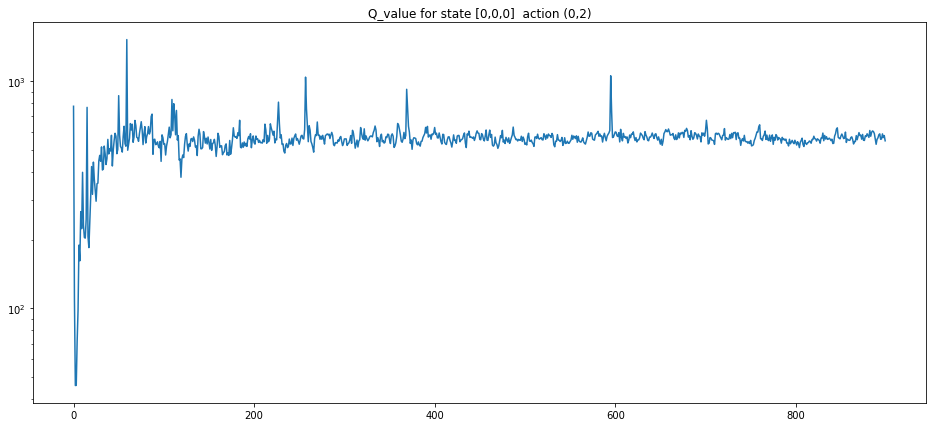

In [13]:
#Plotting the Q-value convergence for state-action pair

plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

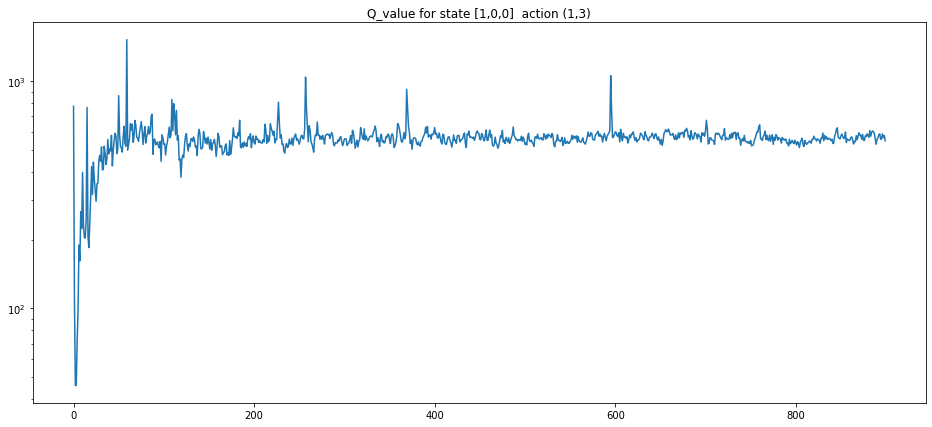

In [14]:
#Plotting the Q-value convergence for state-action pair

plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [1,0,0]  action (1,3)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

#### Tracking rewards per episode

In [15]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

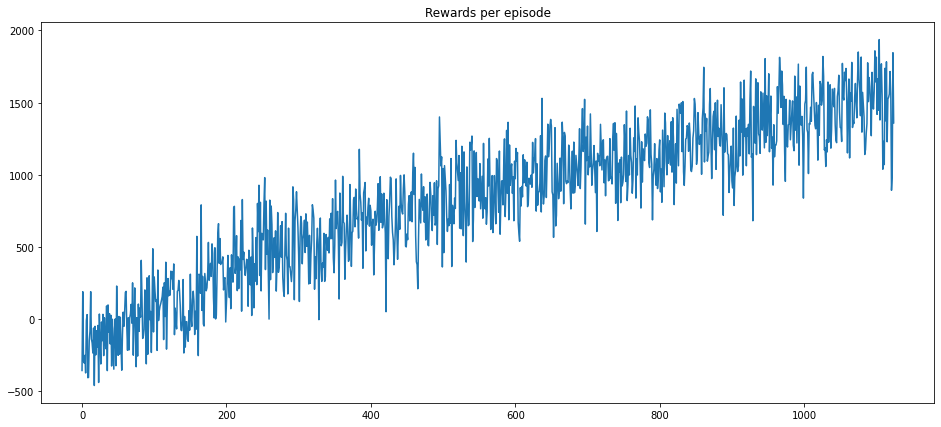

In [16]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

In [17]:
time = np.arange(0,15000)
epsilon = []
for i in range(0,15000):
    epsilon.append((1 - 0.00001) * np.exp(-0.0005 * i))

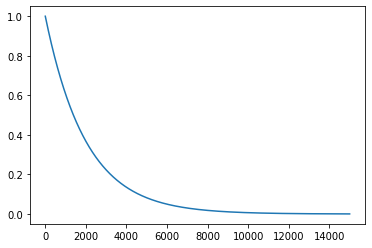

In [18]:
plt.plot(time, epsilon)
plt.show()

##### End of the notebook